### Make DataFrame and ocr_text_dict from jsonl

In [1]:
import pandas as pd
import numpy as np
import os
from utils.OCR_preprocessing import get_row_from_json_for_df, append_item_ocr_text_from_json_to_dict

In [3]:
path_ocrs = os.path.abspath("INPUT_datasets/predict_categories_dataset_ocrs.jsonl.gz")

In [4]:
"""approx time 15sec
Iterating through the jsonl to extract elements for the dataframe and the ocr dictionary.
"""
from IPython.display import clear_output
import gzip
import json
# make df from json
rows = []
ocr_text_dict = {}
with gzip.open(path_ocrs) as f:
    for i, line in enumerate(f):
        #We take lines after 10 000 because those are potentially problematic.
        if i > 10000: 
            json_line = json.loads(line)
            if len(str(json_line['code'])) == 13:
                #for df
                row = get_row_from_json_for_df(json_line)
                rows.append(row)
                #for dict
                append_item_ocr_text_from_json_to_dict(json_line, ocr_text_dict)

df = pd.DataFrame(rows, columns = ["code", "texts", "keys"]).drop_duplicates(subset = "code")
df['code'] = df['code'].astype(str)
df['texts'] = df['texts'].astype(str)
print(df.shape)
print(len(ocr_text_dict))

del rows

(790383, 3)
597242


In [5]:
is_real_ean = df['code'].str.len() == 13
df = df[is_real_ean]
print("after removing non normalized codes", df.shape)
### Keep only texts > 10 char
len_sup_10 = (df["texts"].str.len()> 10)
df = df[len_sup_10]
print("after removing short texts", df.shape)


after removing non normalized codes (790383, 3)
after removing short texts (596550, 3)


### Extract main language from text

for each text associated with a barcode, there are potentially many languages used to describe the product.
The aim of this section is to detect the main language and to extract its text.

In [6]:
PRETRAINED_MODEL_PATH = 'fasttext_weights/lid.176.bin'
from utils.OCR_language_extraction import get_lang_items_from_pd_textlist

In [8]:
"""approx time 2min15"""
text_list, lang_dict_list, main_lang_list = get_lang_items_from_pd_textlist(df['texts'],PRETRAINED_MODEL_PATH)
main_lang_dict = {code: dic for (code,dic) in zip(df["code"], lang_dict_list)}
#assign new items to df
df["text_main_lang"] = text_list
df["main_lang"] = main_lang_list
df.head(2)

100%|██████████| 596550/596550 [02:09<00:00, 4597.32it/s]


,code,texts,keys,text_main_lang,main_lang
0,0021065000071,Nutrition Facts\n24 servings per container\nSe...,[1],Nutrition Facts 24 servings per container Serv...,en
1,0021065000101,Includes 0g Added Sugars 0%\nNutrition Facts\n...,"[2, 1]",Includes 0g Added Sugars 0% Nutrition Facts 71...,en


### Clean the text

In [9]:
from utils.OCR_preprocessing import text_cleaner, parallel_calc

In [10]:
""" Non parallelized version - approx time 2m"""
#df["text_cleaned"] = df["text_main_lang"].apply(lambda x: text_cleaner(x))
#df = df.set_index("code", drop = True)

""" Parallelized version - approx time 30sec"""
# simple wrapper code around text_cleaner to parallelize the work
df["text_main_lang_cleaned"] = parallel_calc(text_cleaner, df["text_main_lang"])

In [11]:
"""approx time 1min"""
df["original_text_cleaned"]  = parallel_calc(text_cleaner, df["texts"])

In [12]:
df.head(3)

,code,texts,keys,text_main_lang,main_lang,text_main_lang_cleaned,original_text_cleaned
0,0021065000071,Nutrition Facts\n24 servings per container\nSe...,[1],Nutrition Facts 24 servings per container Serv...,en,Nutrition Facts servings container Serving Siz...,Nutrition Facts servings container Serving Siz...
1,0021065000101,Includes 0g Added Sugars 0%\nNutrition Facts\n...,"[2, 1]",Includes 0g Added Sugars 0% Nutrition Facts 71...,en,Includes Added Sugars Nutrition Facts servings...,Includes Added Sugars Nutrition Facts servings...
9,0021078019091,SOURCE NATURALS\nDIETARY SUPPLEMENT\nTRUE WHEY...,[1],SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...,en,SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...,SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...


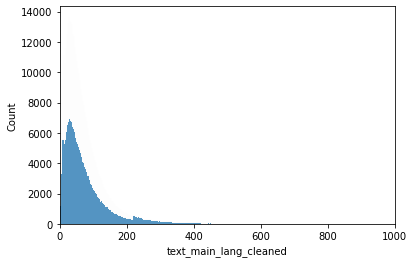

In [13]:
#bump around 210 <-- investigate
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
word_count = df['text_main_lang_cleaned'].str.split().str.len()
sns.histplot(word_count)
plt.xlim([0,1000])
plt.show()


### TFIDF Trick

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import clear_output
from utils.OCR_word_selection import get_freq_dict, get_best_tfidf_words_cleaned
from tqdm import tqdm

df["tfidf_selection"] = ""

In [20]:
"""takes approx 3min30"""

problematic_langs = []
df = df.reset_index(drop = True)
freq_dict = get_freq_dict(df["text_main_lang_cleaned"])
for lang in df["main_lang"].unique():
    print("lang:", lang)
    lang_filter = df["main_lang"]== lang 
    sub_df_text_series = df.loc[lang_filter, "text_main_lang_cleaned"]
    try:
        vectorizer = TfidfVectorizer(max_df = 0.8)
        tfidf_matrix = vectorizer.fit_transform(sub_df_text_series)
        feature_names = vectorizer.get_feature_names_out()
        params = {
            "feature_names": feature_names,
            "text_series": sub_df_text_series,
            "tfidf_matrix": tfidf_matrix,
            "freq_dict": freq_dict,
            "n_max_words_to_pick": 120
            }
        text_selection_list = [get_best_tfidf_words_cleaned(i, **params) for i in tqdm(range(sub_df_text_series.shape[0]))]
        df.loc[lang_filter, "tfidf_selection"] = text_selection_list
    except:
        problematic_langs.append(lang)
    clear_output()

In [21]:
len(problematic_langs)

21

In [22]:
df["tfidf_selection"].str.split().str.len().sort_values(ascending = False)

  0%|          | 0/129236 [13:46<?, ?it/s]


449888    120
123275    120
482053    120
494627    120
118633    120
         ... 
316356      0
315248      0
314763      0
314526      0
528235      0
Name: tfidf_selection, Length: 596550, dtype: int64

### "Intersection words trick"

In [23]:
from utils.OCR_word_selection import get_intersect_words_lang, get_intersect_words_ocr

In [24]:
"""takes approx 1min30"""
intersection_list_lang = parallel_calc(get_intersect_words_lang, lang_dict_list)
print("ratio:", len([item for item in intersection_list_lang if item != ""]) / len(intersection_list_lang))

df["intersection_words_lang"] = intersection_list_lang

ratio: 0.14667169558293522


In [25]:
"""takes approx 56sec"""
sub_ocr_text_dict_list = [ocr_text_dict[code] for code in df["code"]]
intersection_list_ocr = parallel_calc(get_intersect_words_ocr, sub_ocr_text_dict_list)
print("ratio:", len([item for item in intersection_list_ocr if item != ""]) / len(intersection_list_ocr))

df["intersection_words_ocr"] = intersection_list_ocr

ratio: 0.4644656776464672


In [26]:
df["intersection_words_ocr"].str.split().str.len().sort_values(ascending = False)

164374    30
67550     30
279678    30
586477    30
244112    30
          ..
261679     0
261676     0
261675     0
261672     0
596549     0
Name: intersection_words_ocr, Length: 596550, dtype: int64

### Fetch big words from images

In [27]:
import gzip
import json
from utils.OCR_word_selection import get_big_words_from_txt_annotations

In [28]:
from collections import defaultdict
big_words_dict = defaultdict(str)
i_last = -1

In [29]:
"""takes approx 7m30"""
txt_annotations_path = "INPUT_datasets/txtannotations.jsonl.gzip"

with gzip.open(txt_annotations_path) as f:
    for i, line in enumerate(f):
        if i > i_last:
            i_last +=1
            json_str = line.decode('utf-8')
            txt_annotations = json.loads(json_str)
            barcode = list(txt_annotations.keys())[0]
            sentences_list = [get_big_words_from_txt_annotations(txt_annotations[barcode][key]) for key in sorted(txt_annotations[barcode].keys())]
            if len(big_words_dict[str(barcode)]) <= 500:
                big_words_dict[str(barcode)] +=  " " + " ".join(sentences_list)

        if i %250000 == 0:
            print(i)
  

0
250000
500000
750000
1000000


In [30]:
len(big_words_dict)

363547

In [31]:
"""
import pickle
path = "barcodes_dict_with_new_ones.pkl"
with open(path, 'rb') as file:
    big_words_dict = pickle.load(file)
len(big_words_dict)
"""

375415

In [32]:
df["big_words"] = df["code"].apply(lambda x: big_words_dict.get(str(x), ''))

In [33]:
df["big_words"].str.split().str.len().sort_values(ascending = False)

142417    140
141865    112
85698     110
157713    110
190957    110
         ... 
448646      0
448647      0
448648      0
448650      0
596549      0
Name: big_words, Length: 596550, dtype: int64

### Make output df

In [34]:
from utils.OCR_preprocessing import remove_duplicates

In [35]:
"""takes approx 15 sec"""

df["word_selection"] = (
    df["big_words"].astype(str) + ". " +
    df["intersection_words_ocr"].fillna("").astype(str) + ". " +
    df["intersection_words_lang"].fillna("").astype(str) + ". " +
    df.apply(
        lambda x: x["original_text_cleaned"] if len(x["original_text_cleaned"]) < 500 
        else x["text_main_lang_cleaned"]if len(x["text_main_lang_cleaned"]) < 500
        else (remove_duplicates(x["text_main_lang_cleaned"]) if len(remove_duplicates(x["text_main_lang_cleaned"]).split()) < 80
        else x["tfidf_selection"]) ,axis = 1).astype(str)
    )


In [36]:
df[df["word_selection"] == ""].shape

(0, 12)

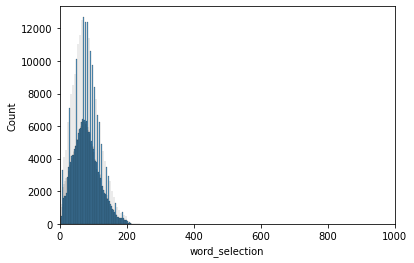

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
word_count = df['word_selection'].str.split().str.len()
sns.histplot(word_count)
plt.xlim([0,1000])
plt.show()


In [38]:
df['word_selection'].str.split().str.len().sort_values(ascending = False)

169446    240
22709     240
169470    235
169108    230
41484     230
         ... 
508168      3
389528      3
397106      3
580967      3
402608      3
Name: word_selection, Length: 596550, dtype: int64

In [518]:
#df.to_pickle("dataset/dataset.pkl")

### Check Results

In [3]:
#df = pd.read_pickle("dataset/dataset.pkl")
#df["code"] = df["code"].astype(str)

In [39]:
empty_or_noise = df["word_selection"].str.len() < 10
print("noise or empty lines:", empty_or_noise.sum())
df = df[~empty_or_noise]
print(df.shape)


noise or empty lines: 193
(596357, 12)


In [40]:
from  utils.OCR_word_selection import show_images_from_barcode, get_big_words_from_image_clean
import re

In [41]:
#i = np.random.choice(range(df.shape[0]))
#i = 10157 # maitre coq volaille 0215703025452
#i = 20865 #knorr 3011360020178
#i = 363851 #bolognese sauce - 5000354914829
#i = 65210 # andouilettes - 3278910707327
#i = 27073 # bonduelle conconmbre fromage blanc  -3083681008616
i = 151249 # macaroni everyday - 5400141165043

barcode = df["code"].iloc[i]
print(i)
print(df["word_selection"].iloc[i])
print(len(df["word_selection"].iloc[i].split()))
print(barcode)
show_images_from_barcode(barcode, df)

151249
Macaroni Everyday MET HAM EN KAAS JAMBON FROMAGE DEPYRIES à Voedingswaarden Valeurs nutritionnelles Zout Sel à RI en tomates Gemiddelde Voedingswaarden Ingrediënten Valeurs nutritionnelles à Macaroni met ham en kaas. à en jambon. . macaronis cuits eau semoule blé dur lait entier jambon viande porc Sel dextrose caséinate Contient du extrait plantes aromatiques épices fumée épaississant stabilisants antioxydant fromage emmental gouda huile tournesol amidon modifié farine bouillon légumes levure extraits céleri oignons poireaux tomates carottes en poudre ail gluten Peut contenir des traces crustacés ceufs poisson arachides soja fruits coque moutarde sésame mollusques Voedingswaarden Valeurs nutritionnelles pore romage toumesol léqumes celeri oufs polsson Gemiddelde voedings waarde nutritionnelle moyenne Fibres alimentaires Elwitten Protéines Zout volwassene Apport etérence un
117
5400141165043


In [42]:
big_words_dict[barcode]

'Macaroni Everyday MET HAM EN KAAS JAMBON FROMAGE DEPYRIES à Voedingswaarden Valeurs nutritionnelles Zout Sel à RI en tomates Gemiddelde Voedingswaarden Ingrediënten Valeurs nutritionnelles à Macaroni met ham en kaas'

In [44]:
input_text = df["texts"].iloc[i]
final_selection = df["word_selection"].iloc[i]
text_clean = df["text_main_lang_cleaned"].iloc[i]
text_tf = df["tfidf_selection"].iloc[i]
text_insct_lang = df["intersection_words_lang"].iloc[i]
text_insct_ocr = df["intersection_words_ocr"].iloc[i]
barcode = df["code"].iloc[i]


print(barcode)
print(re.sub(r"\n", " ", input_text))
print("\n ____ final selection ____")
print(final_selection)
print("\n ____ text of main language after cleaning ____")
print(text_clean)
print("\n ____ text selection with tdidf score")
print(text_tf)
print("\n ____ text selection - intersection between languages ____")
print(text_insct_lang)
print("\n ____ text selection - intersection between OCRs ____")
print(text_insct_ocr)
print("\n ___ text selection - big words from image ____")
if barcode in big_words_dict:
    print(big_words_dict[barcode])

5400141165043
Ingrediënten Ingredients Macaroni met ham en kaas 34% gekookte macaroni (water, griesmeel van harde tarwe), volle melk, water, 11 % ham [varkensvlees, water, zout, dextrose, caseinaat (bevat melk), kruidenextract, kruiden en specerijen, rookextract, vieesextract verdikkingsmiddel (E407a), stabilisatoren (E450, E451), antioxidant (E301), 9,8 % kaas (emmentaler, gouda), zonnebloemolie, gemodificeerd zetmeel, tarwebloem, groentebouillon (zout, gistextract, zetmeel, zonnebloemolie, groente-extracten (selderij, uien, prei, tomaten, wortelen), uienpoeder, knoflook, kruiden en specerijen), specerijen. Bevat gluten, melk en selderij. Kan sporen van schaaldieren, eieren, vis, pinda, soja, noten, mosterd, sesam en weekdieren bevatten. Macaroni jambon-fromage 34 % macaronis cuits (eau, semoule de blé dur), lait entier, eau, 11 % jambon (viande de porc, eau, sel, dextrose, caséinate (contient du lait), extrait de plantes aromatiques, plantes aromatiques et épices, extrait de fumée, e

In [45]:
barcode = "3560070851003"
get_big_words_from_image_clean(barcode, df = df)

'ALM SAUMON ATLANTISCHE ATLANTIQUE Pavés BEVROREN CONGELÉ Moten Qualité sans arête peau Kwaliteit zonder graat ZALM SAUMON ATLANTIQUE ATLANTISCHE BEVROREN Moten Pavés CONGELÉ Nettogewicht Qualité FILIÈRE sans arête peau Kwaliteit'